## Model Training to test [Gradient ]
---


Training R2: 0.9999780130941882
Test R2: 0.9917344645696976
Training RMSE: 0.0005026355260336904
Test RMSE: 0.010337720606777198


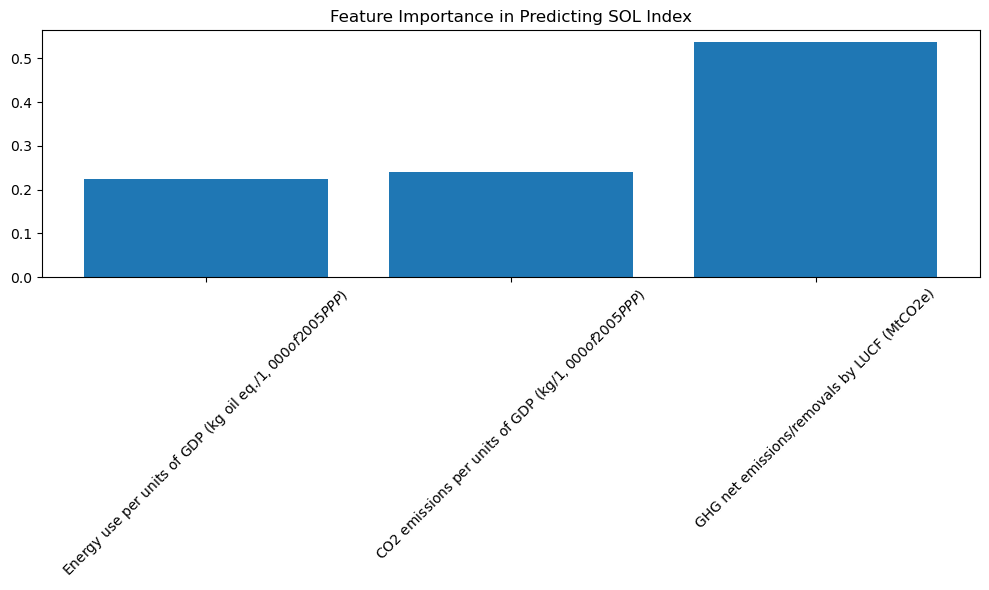

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


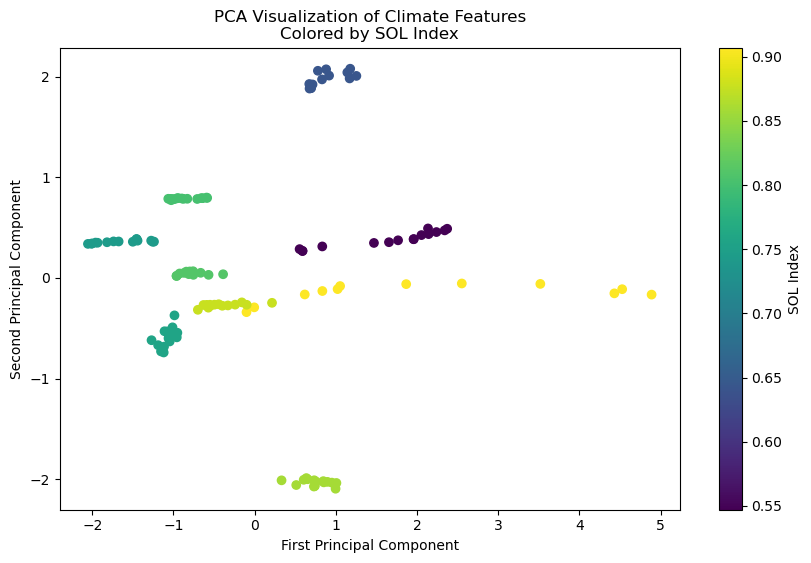

In [1]:

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Read and prepare data
clean_cc_data = pd.read_excel('check.xlsx')

# Compute SOL index (reusing code from DT.ipynb)
# detect country column
country_col = [c for c in clean_cc_data.columns if c.lower().startswith('country')][0]

# Define SOL components
sol_cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    'Urban population': 'urban_pop',
    'Access to improved sanitation (% of total pop.)': 'sanitation',
    'Access to improved water source (% of total pop.)': 'water'
}

# Group by country
country_means = clean_cc_data.groupby(country_col)[list(sol_cols.keys())].mean().reset_index()
country_means = country_means.rename(columns=sol_cols)

# Normalize components
mort_max = country_means['under5'].replace(0, np.nan).max() or 1.0
phys_max = country_means['physicians'].replace(0, np.nan).max() or 1.0

# Compute SOL components
components = {
    'E_primary': country_means['primary'] / 100.0,
    'H_under5': 1.0 - (country_means['under5'] / mort_max),
    'P_physicians': country_means['physicians'] / phys_max,
    'I_gni': country_means['gni'] / 100.0,
    'Pov_not': 1.0 - (country_means['poverty'] / 100.0),
    'R_roads': country_means['paved_roads'] / 100.0,
    'U_urban': country_means['urban_pop'] / 100.0,
    'W_water': country_means['water'] / 100.0,
    'S_sanitation': country_means['sanitation'] / 100.0
}

# Add components to dataframe
for name, values in components.items():
    country_means[name] = values.clip(0, 1)

# Calculate weighted SOL
weights = {
    'E_primary': 0.15, 'H_under5': 0.15, 'I_gni': 0.15,
    'P_physicians': 0.10, 'Pov_not': 0.10, 'R_roads': 0.10,
    'U_urban': 0.05, 'W_water': 0.10, 'S_sanitation': 0.10
}

country_means['SOL_index'] = sum(country_means[k] * w for k, w in weights.items())

# Prepare features for GBR
feature_cols = [
    'Energy use per units of GDP (kg oil eq./$1,000 of 2005 PPP $)',
    'CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)',
    'GHG net emissions/removals by LUCF (MtCO2e)'
]
clean_cc_data = clean_cc_data.merge(country_means[[country_col,'SOL_index']], on=country_col, how='left')
X = clean_cc_data[feature_cols]
y = clean_cc_data['SOL_index']

# Drop rows with NaN in y
clean_cc_data = clean_cc_data.dropna(subset=['SOL_index'])

# Prepare features and target variable again after dropping NaN
X = clean_cc_data[feature_cols]
y = clean_cc_data['SOL_index']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train GBR
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train_scaled, y_train)

# Predictions and metrics
train_pred = gbr.predict(X_train_scaled)
test_pred = gbr.predict(X_test_scaled)

print("Training R2:", r2_score(y_train, train_pred))
print("Test R2:", r2_score(y_test, test_pred))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(feature_cols, gbr.feature_importances_)
plt.xticks(rotation=45)
plt.title('Feature Importance in Predicting SOL Index')
plt.tight_layout()
plt.show()

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

# Plot clusters with SOL index as color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter, label='SOL Index')
plt.title('PCA Visualization of Climate Features\nColored by SOL Index')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Optional: Save model
# import joblib
# joblib.dump(gbr, 'sol_predictor.joblib')